# Notebook Structure

- Settings
- Imports
- Data Preprocessing
- GP Model
- Results
- Plots

# Usage

New models are trained each time the notebook is run. Trained models are not saved. (Saving a trained model is quite simple to implement, check [GPyTorch documentation](https://docs.gpytorch.ai/en/stable/index.html) for information.)

Results are saved into "results" folder. Plots are not saved, they can be viewed in this notebook in "Plots" section after running the notebook.

# Optimization of the Model

I have marked the optimizable or changeable components with "# Optimizable" comments. For example the whole feature extractor or mean and covariance functions can be changed for optimization purposes. For GP specific components, check [GPyTorch documentation](https://docs.gpytorch.ai/en/stable/index.html) for kernels (covariance functions) and means etc.

# Changing the Dataset

The dataset can be changed by specifying the file paths in settings below. The columns (structure and column names) of the new dataset must be identical to the old ones, and the sample names must match between sample info dataframe and reflectance files (check preprocessing for more info). If the data structure of a new dataset is different from the standard, changes must be made directly in the code (data preprocessing section) to account for it. The correct dataframe or data format should be checked in respective files (listed below).

Alternatively one can use an already preprocessed dataframe, in which case the "overwrite_preprocessed_data" variable should be set to false, and "preprocessed_data_path" variable should be set to lead to the correct CSV file. The correct structure of the preprocessed data can be checked in the corresponding file (listed below).

The number of wavelengths in the raw or preprocessed data can be freely changed in the data files or in the preprocessing section of the code. Although the number of wavelengths in the data files can be freely changed between datasets, the overall structure of the dataframes should stay identical (columns, column names, etc.). No changes should be needed for the model itself.

Check the corresponding files for the correct array/dataframe/data structures for raw data:
- data/data_all_no0_only_important.csv
- data/reflectance_data/

Or check the corresponding file for the correct array/dataframe/data structures for preprocessed data:
- data/combined_data_550-2250.csv

#### Changing Only the Wavelength Preprocessing

The preprocessing can be changed in "Interpolate and Normalize Data" section in "Data Preprocessing" to change the number and range of wavelengths in preprocessed data.

# Settings

In [3]:
# File paths
sample_info_path = 'data/data_all_no0_only_important.csv' # Sample info
reflectance_data_folder = 'data/reflectance_data' # Reflectance data folder
preprocessed_data_path = 'data/combined_data_550-2250.csv' # Preprocessed dataframe is saved here
ensemble_model_result_path = 'data/Ensemble_CNN_Tree_30repeat.xlsx' # Ensemble model predictions
ensemble_GP_RMSE_split_comparison_path = 'results/GP_Ensemble_RMSE_split_comparison.xlsx' # Save path for results

overwrite_preprocessed_data = True # (In data folder), Overwrite "preprocessed_data_path"?
save_RMSE_comaprison_results = True # (In results folder)

cycles = 30 # Number of models used for evaluation. Affects the running time.
training_iterations = 150 # Optimizable, Default 150, optimal iteration count may change if model is modified
folds = 7 # Number of folds in cross validation

# Irradiation types
irradiation_types = { # This dict is only a note to remember the irradiation types, it is not used in the code
    1: "I_H_OL",
    2: "I_H_PX",
    3: "I_H_M",
    4: "I_Ar_OL",
    5: "I_Ar_PX",
    6: "I_Ar_M",
    7: "I_He_OL",
    8: "I_He_PX",
    9: "I_He_M",
    10: "L_OL",
    11: "L_PX",
    12: "L_M"
}

'''
Irradiation type combinations
Hydrogen + laser on only olivine = 1, 10
Hydrogen + laser on all minerals = 1, 2, 3, 10, 11, 12
All = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
'''

selected_irradiations = [1, 2, 3, 10, 11, 12] # Select which irradiation types are considered in the training dataset. The GP tasks are divided based on this list.

# Imports

In [4]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
import gpytorch
from sklearn.model_selection import KFold
from math_functions import mean_squared_error, root_mean_squared_error, denoise_and_norm
from sklearn.metrics import r2_score
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data preprocessing

Loads the data, combines the sample info and spectra into a dataframe, interpolates and normalizes the data, selects the number and range of wavelengths for the data, and saves the preprocessed dataframe into a CSV file.

#### Sample Information

In [5]:
sample_info = pd.read_csv(sample_info_path, dtype={'Sample name': str, 'Irradiation': int, 'ET_1AU': float, 'group': int})

print(sample_info.dtypes, '\n')
sample_info

Sample name     object
Irradiation      int64
ET_1AU         float64
group            int64
dtype: object 



,Sample name,Irradiation,ET_1AU,group
0,PO_TXH_007,10,3.382378e+08,8
1,PO_TXH_008,10,6.764756e+08,8
2,PO_TXH_081_CP1,10,3.382378e+08,8
3,PO_TXH_081_CP2,10,6.764756e+08,8
4,RB_LE4OLV,10,7.610350e+08,8
...,...,...,...,...
204,OC_LP_A2_3,3,2.361833e+02,2
205,OC_LP_A3_3,3,5.992057e+02,2
206,MJL_OLV_1,9,1.001362e+03,3
207,MJL_OLV_2,9,3.538145e+03,3


#### Load Wavelength and Reflectance

In [6]:
too_large_first_wavelength = ['MJL_OLV_1', 'MJL_OLV_2', 'MJL_OLV_3']# These have too large first wavelength
discarded_samples = ['KC_OL_lm_12', 'KC_OL_lvn_12', 'RB_LE3CPX', 'KC_OPX_lvn_11', 'KC_OPX_lm_11', 'TJ_OPX_1'] # Discarded because exposure times were unrealisticly high
unwanted_samples = too_large_first_wavelength + discarded_samples

# Initialize empty dictionaries to hold data for W and R
w_data = {}
r_data = {}

# Iterate through the extracted files and process CSV files
for root, dirs, files in os.walk(reflectance_data_folder):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path, header=None)

            # Extract the filename without extension to use as column header
            file_name = file.split('.')[0]
            if file_name in sample_info['Sample name'].values and file_name not in unwanted_samples:
                df.columns = df.iloc[1]
                df = df[2:].astype(float)

                wavelengths = df["W"].to_numpy() * 1000
                reflectances = df["R"].to_numpy()

                w_data[file_name] = wavelengths
                r_data[file_name] = reflectances

#### Preprocess Wavelength Data

In [7]:
max_first_wavelength = float('-inf')
for key, value in w_data.items():
    if value[0] > max_first_wavelength:
        max_first_wavelength = value[0]
print(max_first_wavelength)

min_last_wavelength = float('inf')
for key, value in w_data.items():
    if value[-1] < min_last_wavelength:
        min_last_wavelength = value[-1]
print(min_last_wavelength)

# Convert the dictionaries to DataFrames
w_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in w_data.items()]))

w_df

540.88
2480.84157


,OC_LP_B2_1,KC_OPX_hevn_1,KC_OPX_lm_9,OC_TXH_011_A60,RB_LE4OLV,KC_OL_arvn_5,OWN_OL4_EN1_1,MY_OL_30,XT_TXH_030_P2,KC_OPX_lm_8,...,KC_OPX_lvn_1,KC_OPX_lvn_10,OC_TXH_013_P05,KC_OPX_hevn_3,KC_OL_hm_2,OC_LP_A3_1,KC_OPX_arvn_5,RB_LE2CPX,KC_OL_arm_1,OC_LP_A2_2
0,250.0,540.88,500.12,300.0,250.0,540.88,496.605913,255.855137,280.0,500.12,...,450.10,450.10,250.0,540.88,500.12,250.0,540.88,250.0,500.12,250.0
1,255.0,541.33,500.31,305.0,251.0,541.33,498.919256,258.242041,285.0,500.31,...,450.26,450.26,255.0,541.33,500.31,255.0,541.33,251.0,500.31,255.0
2,260.0,541.79,500.50,310.0,252.0,541.79,500.461484,261.023115,290.0,500.50,...,450.42,450.42,260.0,541.79,500.50,260.0,541.79,252.0,500.50,260.0
3,265.0,542.24,500.70,315.0,253.0,542.24,502.260751,263.815131,295.0,500.70,...,450.57,450.57,265.0,542.24,500.70,265.0,542.24,253.0,500.70,265.0
4,270.0,542.69,500.89,320.0,254.0,542.69,503.288903,266.194741,300.0,500.89,...,450.73,450.73,270.0,542.69,500.89,270.0,542.69,254.0,500.89,270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2494.10,2494.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2495.30,2495.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2496.50,2496.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2497.70,2497.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Preprocess Reflectance Data

In [8]:
r_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in r_data.items()]))

r_df

,OC_LP_B2_1,KC_OPX_hevn_1,KC_OPX_lm_9,OC_TXH_011_A60,RB_LE4OLV,KC_OL_arvn_5,OWN_OL4_EN1_1,MY_OL_30,XT_TXH_030_P2,KC_OPX_lm_8,...,KC_OPX_lvn_1,KC_OPX_lvn_10,OC_TXH_013_P05,KC_OPX_hevn_3,KC_OL_hm_2,OC_LP_A3_1,KC_OPX_arvn_5,RB_LE2CPX,KC_OL_arm_1,OC_LP_A2_2
0,0.091267,0.30316,0.17514,0.08142,0.102687,0.69376,0.222230,0.078070,0.19662,0.18813,...,0.29841,0.10807,0.087242,0.29999,0.66890,0.073795,0.30564,0.139433,0.45412,0.068925
1,0.095063,0.30342,0.15834,0.08278,0.102185,0.69462,0.222707,0.079495,0.14896,0.18181,...,0.29947,0.10395,0.088632,0.30073,0.66179,0.075704,0.30569,0.138631,0.44680,0.070946
2,0.099236,0.30346,0.15316,0.08263,0.102471,0.69529,0.223281,0.080919,0.13586,0.16909,...,0.29177,0.10738,0.088888,0.30058,0.66537,0.077820,0.30536,0.138315,0.44301,0.073034
3,0.103076,0.30354,0.15552,0.08353,0.102007,0.69547,0.223663,0.083058,0.13219,0.16247,...,0.28526,0.11490,0.087427,0.30090,0.66944,0.079724,0.30506,0.138342,0.43171,0.074928
4,0.107064,0.30343,0.15903,0.08438,0.101547,0.69554,0.224141,0.084007,0.13455,0.16843,...,0.28488,0.13047,0.088377,0.30071,0.66752,0.081352,0.30471,0.137929,0.43110,0.076659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54237,0.43920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54303,0.43950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54355,0.43975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54356,0.43966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Interpolate and Normalize Data

The number and range of considered wavelengths can be changes in the following code cell. The variable "interpolation_wavelengths" determines the wavelengths, and it can be freely changed.

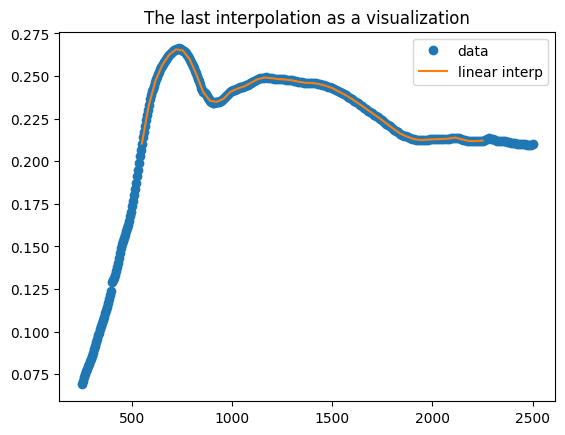

,OC_LP_B2_1,KC_OPX_hevn_1,KC_OPX_lm_9,OC_TXH_011_A60,RB_LE4OLV,KC_OL_arvn_5,OWN_OL4_EN1_1,MY_OL_30,XT_TXH_030_P2,KC_OPX_lm_8,...,KC_OPX_lvn_1,KC_OPX_lvn_10,OC_TXH_013_P05,KC_OPX_hevn_3,KC_OL_hm_2,OC_LP_A3_1,KC_OPX_arvn_5,RB_LE2CPX,KC_OL_arm_1,OC_LP_A2_2
550.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
584.0,1.025818,1.023912,1.085563,1.038690,1.048641,1.012260,1.037647,1.063113,1.028520,1.101411,...,1.050305,1.090798,1.017611,1.025000,1.006495,1.088583,1.030655,1.035233,1.038322,1.105729
618.0,1.041532,1.056567,1.172919,1.068086,1.077656,1.007257,1.074555,1.109795,1.031543,1.182591,...,1.083221,1.163220,1.033550,1.061388,1.001083,1.151232,1.071262,1.065463,1.056541,1.175916
652.0,1.056156,1.101019,1.254283,1.096362,1.110248,1.008834,1.107209,1.143272,1.046723,1.254749,...,1.119670,1.229345,1.051170,1.110001,1.007799,1.191792,1.102640,1.092927,1.079361,1.219676
686.0,1.065866,1.144549,1.320872,1.113485,1.146285,1.009464,1.139044,1.185546,1.071987,1.329229,...,1.161474,1.286154,1.065420,1.147666,1.010311,1.219460,1.153756,1.119006,1.098171,1.247651
720.0,1.070456,1.187161,1.377180,1.115344,1.146664,0.983658,1.165315,1.198987,1.082094,1.380829,...,1.199106,1.328543,1.079248,1.188370,0.984608,1.236806,1.205637,1.159498,1.097729,1.263192
754.0,1.061514,1.214569,1.357387,1.100633,1.138979,0.940578,1.186650,1.194375,1.043446,1.365064,...,1.193812,1.311839,1.084272,1.213442,0.937861,1.236653,1.231927,1.189243,1.071949,1.260106
788.0,1.034156,1.152679,1.222129,1.060663,1.103010,0.890738,1.195784,1.178256,0.941096,1.239008,...,1.104968,1.193353,1.074962,1.145232,0.884774,1.217217,1.178402,1.230141,1.040170,1.236116
822.0,0.990079,1.017062,1.015402,1.000615,1.083838,0.850030,1.195788,1.154509,0.790606,1.032367,...,0.933553,1.005976,1.056105,1.008453,0.843718,1.178752,1.042542,1.264141,1.011377,1.193089
856.0,0.938160,0.877875,0.816616,0.935963,1.066920,0.826343,1.192161,1.158415,0.654814,0.838159,...,0.777054,0.819551,1.028452,0.872187,0.817458,1.122173,0.900563,1.257603,0.997408,1.143957


In [9]:
use_denoising_and_normalization = True
only_normalization = False
number_of_wavelengths = 51

# interpolation_wavelengths = np.linspace(541., 2424., number_of_wavelengths)
interpolation_wavelengths = np.linspace(550., 2250., number_of_wavelengths)
interpolation_dict = {}

for i in range(len(w_df.columns)):
	wavelengths = w_df.iloc[:, i].to_numpy()
	unique_wavelengths, unique_indices = np.unique(wavelengths, return_index=True)

	reflectances = r_df.iloc[:, i].to_numpy()
	unique_reflectances = reflectances[unique_indices]

	interpolation = np.interp(interpolation_wavelengths, unique_wavelengths, unique_reflectances)

	if use_denoising_and_normalization:
		denoised_normalized_data = denoise_and_norm(interpolation, interpolation_wavelengths, denoising=True, normalising=True)
		denoised_normalized_data = denoised_normalized_data.flatten()
		interpolation_dict[w_df.columns[i]] = denoised_normalized_data
		normalized_interpolation = interpolation / interpolation[0]
		# print(np.mean((denoised_normalized_data - normalized_interpolation) ** 2)) # Similarity of own and Davids methods
		# print(np.array_equal(denoised_normalized_data, normalized_interpolation))
	elif only_normalization:
		normalized_interpolation = interpolation / interpolation[0]
		interpolation_dict[w_df.columns[i]] = normalized_interpolation
	else:
		interpolation_dict[w_df.columns[i]] = interpolation

interpolation_df = pd.DataFrame(interpolation_dict, index=interpolation_wavelengths)
#interpolation_df = interpolation_df.transpose()

plt.plot(unique_wavelengths, unique_reflectances, 'o', label='data')
plt.plot(interpolation_wavelengths, interpolation, '-', label='linear interp')
plt.legend(loc='best')
plt.title('The last interpolation as a visualization')
plt.show()

interpolation_df

#### Combine Sample Info and Reflectance Data

In [10]:
reflectance_data_transposed = interpolation_df.T
reflectance_data_transposed.reset_index(inplace=True)
reflectance_data_transposed.rename(columns={'index': 'Sample name'}, inplace=True)

# Merge sample_info with the transposed reflectance_data
merged_data = pd.merge(sample_info, reflectance_data_transposed, on='Sample name')
merged_data

,Sample name,Irradiation,ET_1AU,group,550.0,584.0,618.0,652.0,686.0,720.0,...,1944.0,1978.0,2012.0,2046.0,2080.0,2114.0,2148.0,2182.0,2216.0,2250.0
0,PO_TXH_007,10,3.382378e+08,8,1.0,1.007878,0.988193,0.982036,0.981669,0.948793,...,1.191461,1.190995,1.194271,1.193846,1.195411,1.199186,1.198067,1.197574,1.200647,1.202141
1,PO_TXH_008,10,6.764756e+08,8,1.0,1.009224,0.993181,0.989376,0.990417,0.958965,...,1.216220,1.214997,1.216873,1.218533,1.218845,1.223721,1.223077,1.223112,1.226167,1.228659
2,PO_TXH_081_CP1,10,3.382378e+08,8,1.0,1.024809,1.028070,1.038039,1.045095,1.016770,...,1.311319,1.312123,1.317130,1.318421,1.321785,1.323010,1.320729,1.323559,1.321747,1.318766
3,PO_TXH_081_CP2,10,6.764756e+08,8,1.0,1.045083,1.057163,1.080219,1.080057,1.069199,...,1.510710,1.515629,1.522968,1.524898,1.527924,1.532406,1.532107,1.532269,1.540105,1.532981
4,RB_LE4OLV,10,7.610350e+08,8,1.0,1.048641,1.077656,1.110248,1.146285,1.146664,...,2.236935,2.278695,2.313884,2.339006,2.351942,2.370500,2.391162,2.417522,2.421736,2.440278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,OC_LP_A2_2,3,2.361833e+02,2,1.0,1.105729,1.175916,1.219676,1.247651,1.263192,...,1.010004,1.011335,1.012174,1.012669,1.014064,1.016990,1.011704,1.007090,1.007014,1.008625
196,OC_LP_A3_2,3,5.992057e+02,2,1.0,1.097169,1.163768,1.207710,1.237273,1.255537,...,1.048189,1.050554,1.051604,1.053263,1.054960,1.058765,1.052953,1.048257,1.050416,1.053120
197,OC_LP_A1_3,3,9.491069e+01,1,1.0,1.098777,1.162888,1.200541,1.222890,1.234319,...,0.949880,0.950406,0.951033,0.949815,0.951064,0.950365,0.941783,0.940278,0.939529,0.940415
198,OC_LP_A2_3,3,2.361833e+02,2,1.0,1.101528,1.169834,1.211440,1.236943,1.251505,...,0.997011,0.998404,0.999469,0.998505,1.000379,0.999339,0.990166,0.988745,0.989049,0.990642


#### Save the Data

In [11]:
if overwrite_preprocessed_data:
	merged_data.to_csv(preprocessed_data_path, index=False)

#### Prepare the Data for the Model

In [12]:
data = pd.read_csv(preprocessed_data_path)
data['ET_1AU'].describe()

count    2.000000e+02
mean     6.074343e+08
std      1.012104e+09
min      4.373764e-02
25%      6.675746e+02
50%      3.089238e+08
75%      8.054287e+08
max      6.764756e+09
Name: ET_1AU, dtype: float64

In [13]:
counts = data['Irradiation'].value_counts()
print(counts)
data['ET_1AU'] = np.log10(data['ET_1AU']+1) # Scale the target to log10

num_of_data_rows = data.shape[0]
print(num_of_data_rows)

data

10    58
12    46
11    24
3     18
1     12
2     10
4      9
5      7
7      6
8      5
6      5
Name: Irradiation, dtype: int64
200


,Sample name,Irradiation,ET_1AU,group,550.0,584.0,618.0,652.0,686.0,720.0,...,1944.0,1978.0,2012.0,2046.0,2080.0,2114.0,2148.0,2182.0,2216.0,2250.0
0,PO_TXH_007,10,8.529222,8,1.0,1.007878,0.988193,0.982036,0.981669,0.948793,...,1.191461,1.190995,1.194271,1.193846,1.195411,1.199186,1.198067,1.197574,1.200647,1.202141
1,PO_TXH_008,10,8.830252,8,1.0,1.009224,0.993181,0.989376,0.990417,0.958965,...,1.216220,1.214997,1.216873,1.218533,1.218845,1.223721,1.223077,1.223112,1.226167,1.228659
2,PO_TXH_081_CP1,10,8.529222,8,1.0,1.024809,1.028070,1.038039,1.045095,1.016770,...,1.311319,1.312123,1.317130,1.318421,1.321785,1.323010,1.320729,1.323559,1.321747,1.318766
3,PO_TXH_081_CP2,10,8.830252,8,1.0,1.045083,1.057163,1.080219,1.080057,1.069199,...,1.510710,1.515629,1.522968,1.524898,1.527924,1.532406,1.532107,1.532269,1.540105,1.532981
4,RB_LE4OLV,10,8.881405,8,1.0,1.048641,1.077656,1.110248,1.146285,1.146664,...,2.236935,2.278695,2.313884,2.339006,2.351942,2.370500,2.391162,2.417522,2.421736,2.440278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,OC_LP_A2_2,3,2.375084,2,1.0,1.105729,1.175916,1.219676,1.247651,1.263192,...,1.010004,1.011335,1.012174,1.012669,1.014064,1.016990,1.011704,1.007090,1.007014,1.008625
196,OC_LP_A3_2,3,2.778300,2,1.0,1.097169,1.163768,1.207710,1.237273,1.255537,...,1.048189,1.050554,1.051604,1.053263,1.054960,1.058765,1.052953,1.048257,1.050416,1.053120
197,OC_LP_A1_3,3,1.981867,1,1.0,1.098777,1.162888,1.200541,1.222890,1.234319,...,0.949880,0.950406,0.951033,0.949815,0.951064,0.950365,0.941783,0.940278,0.939529,0.940415
198,OC_LP_A2_3,3,2.375084,2,1.0,1.101528,1.169834,1.211440,1.236943,1.251505,...,0.997011,0.998404,0.999469,0.998505,1.000379,0.999339,0.990166,0.988745,0.989049,0.990642


In [14]:
X_task_sets = [] # list[ np[task 1 X], np[task 2 X], [...], ...]
y_task_sets = [] # list[ np[task 1 y], np[task 2 y], [...], ...]

# Save indices for RMSE calculations. This keeps track of the asteroid IDs for GP model tasks
sample_id_task_sets = [] # list[ np[task 1 indices], np[task 2 indices], [...], ...]

# Separate different irradiation types into tasks. (Tasks are the different GP model categories for different irradiation types)
for task in selected_irradiations:
	task_set = data[data['Irradiation'].isin([task])].copy()
	if len(task_set)==0:
		continue
	task_indices = task_set.index.to_numpy()
	sample_id_task_sets.append(task_indices)
	task_set.drop(['Sample name', 'Irradiation', 'group'], axis=1, inplace=True)
	X = task_set.drop('ET_1AU', axis=1).values
	y = task_set['ET_1AU'].values
	X_task_sets.append(X)
	y_task_sets.append(y)

# Number of data for different tasks
number_of_total_data_points = 0
for task in y_task_sets:
	number_of_total_data_points += len(task)
	print(len(task))
print(f'Total {number_of_total_data_points}')

12
10
18
58
24
46
Total 168


In [15]:
data_dim = X.shape[-1] # Number of considered wavelengths
print(data_dim)

51


# GP Model

#### Feature Extractor

The feature extractor's output is same size as the input.

In [16]:
class FeatureExtractor(torch.nn.Module): # Optimizable (entire feature extractor)
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding='same') # Convolutional layer
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2) # reduces the dimensionality
        self.fc1 = torch.nn.Linear((data_dim // 2) * 16, data_dim) # Fully connected layer, reduces dimensionality

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension: (batch_size, 1, data_dim)
        x = F.relu(self.conv1(x))  # Apply convolution, batch norm, and ReLU
        x = self.pool(x)  # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor: (batch_size, 16 * (data_dim // 2))
        x = self.fc1(x)  # Apply linear layer: (batch_size, data_dim)
        return x

#### model training

In [17]:
kf = KFold(n_splits=folds, shuffle=True)

results_per_id = np.full((num_of_data_rows, cycles), np.nan) # Array for prediction results
true_values_per_id = np.full((num_of_data_rows, 1), np.nan) # True target values

In [18]:
for cycle in range(cycles):
	fold = 1

	# Keep track of indices for RMSE calculations
	data_fold_indexes = [] # [[(train_index, test_index), (train_index, test_index), ...], [...], [...], [...], [...]] = for tasks, for kfold_split
	for task in range(len(X_task_sets)):
		data_fold_indexes.append([])
		for train_index, test_index in kf.split(X_task_sets[task]):
			data_fold_indexes[-1].append((train_index, test_index))

	for data_fold in range(folds): # Cross validation
		print(f'Cycle {cycle+1}/{cycles}')
		print(f'Fold {fold}/{folds}')
		fold += 1

		X_train_list = []
		X_test_list = []
		y_train_list = []
		y_test_list = [] # list[ tensor[y, y, ...], tensor[...], ...]
		train_i_task_list = []
		test_i_task_list = []

		original_indices_of_test_folds = [] # list[ list[id, id, ...], list[...], ...] # Keep track of data IDs

		# Process data for each task
		for task in range(len(X_task_sets)):
			train_index, test_index = data_fold_indexes[task][data_fold]

			X_train, X_test = X_task_sets[task][train_index], X_task_sets[task][test_index]
			y_train, y_test = y_task_sets[task][train_index], y_task_sets[task][test_index]

			original_indices_of_test_fold = sample_id_task_sets[task][test_index]

			X_train = torch.tensor(X_train, dtype=torch.float32)
			X_test = torch.tensor(X_test, dtype=torch.float32)
			y_train = torch.tensor(y_train, dtype=torch.float32)
			y_test = torch.tensor(y_test, dtype=torch.float32)

			X_train_list.append(X_train)
			X_test_list.append(X_test)
			y_train_list.append(y_train)
			y_test_list.append(y_test)
			train_i_task_list.append(torch.full((X_train.shape[0],1), dtype=torch.long, fill_value=task))
			test_i_task_list.append(torch.full((X_test.shape[0],1), dtype=torch.long, fill_value=task))

			original_indices_of_test_folds.append(original_indices_of_test_fold)

		full_X_train = torch.cat(X_train_list)
		full_train_i = torch.cat(train_i_task_list)
		full_y_train = torch.cat(y_train_list)

		# print(full_X_train)
		# print(full_train_i)
		# print(full_y_train)

		full_X_test = torch.cat(X_test_list)
		full_test_i = torch.cat(test_i_task_list)
		full_y_test = torch.cat(y_test_list) # tensor[y, y, y, ...]
		
		full_original_indices_of_test_folds = [] # list[id, id, id, ...]
		for sublist in original_indices_of_test_folds:
			full_original_indices_of_test_folds.extend(sublist)
		# print(len(full_y_test), len(full_original_indices_of_test_folds))
		# print(full_y_test)
		# print(full_original_indices_of_test_folds)

		feature_extractor = FeatureExtractor()

		# The model itself
		class MultitaskGPModel(gpytorch.models.ExactGP):
			def __init__(self, train_x, train_y, likelihood):
				super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
				self.mean_module = gpytorch.means.ConstantMean() # Mean function, Optimizable (check GPyTorch documentation for more info)
				self.covar_module = gpytorch.kernels.keops.MaternKernel(nu=0.5) # Covariance function, Optimizable (check GPyTorch documentation for more info)
				self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=len(X_task_sets), rank=3) # Task-to-task covariance function, Optimizable (check GPyTorch documentation for more info)
				self.feature_extractor = feature_extractor
				self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.) # Scaling/normalization

			def forward(self, x, i):
				extracted_features = self.feature_extractor(x)
	
				# Ensure extracted features are scaled appropriately
				extracted_features = self.scale_to_bounds(extracted_features)

				mean_x = self.mean_module(extracted_features)

				# Get input-input covariance
				covar_x = self.covar_module(extracted_features)
				# Get task-task covariance
				covar_i = self.task_covar_module(i)
				# Multiply the two together to get the covariance we want
				covar = covar_x.mul(covar_i)

				return gpytorch.distributions.MultivariateNormal(mean_x, covar)

			
		likelihood = gpytorch.likelihoods.GaussianLikelihood() # Standard component in GP models
		model = MultitaskGPModel((full_X_train, full_train_i), full_y_train, likelihood) # full_train_i tells the model which task each data point belongs

		model.train()
		likelihood.train()

		optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # Optimizable, Adam optimizer is widely used, learning rate can be changed

		# "Loss" for GPs - the marginal log likelihood
		mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) # Standard component in GP models

		# Training loop
		counter = -1
		iterator = tqdm.notebook.tqdm(range(training_iterations))
		for i in iterator:
			counter += 1
			with gpytorch.settings.cholesky_max_tries(5):
				optimizer.zero_grad()
				output = model(full_X_train, full_train_i)
				loss = -mll(output, full_y_train)
				loss.backward()
				iterator.set_postfix(loss=loss.item())
				optimizer.step()

		# Evaluation
		model.eval()
		likelihood.eval()
		with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
			y_preds = likelihood(model(full_X_test, full_test_i))
			mean = y_preds.mean # The means are used as prediction values
			lower, upper = y_preds.confidence_region() # GP model's own confidence bounds (not using these at the moment)

		y_test_np = full_y_test.numpy()
		mean = mean.numpy()
		lower = lower.numpy()
		upper = upper.numpy()

		# Append the results
		for i, y_test_point in enumerate(y_test_np):
			results_per_id[full_original_indices_of_test_folds[i], cycle] = mean[i]
			if cycle == 0:
				true_values_per_id[full_original_indices_of_test_folds[i], 0] = y_test_point

Cycle 1/3
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

/home/sysa/.pyenv/versions/3.10.3/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Cycle 1/3
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/3
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/3
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/3
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/3
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 1/3
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/3
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/3
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/3
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/3
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/3
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/3
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 2/3
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/3
Fold 1/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/3
Fold 2/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/3
Fold 3/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/3
Fold 4/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/3
Fold 5/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/3
Fold 6/7


  0%|          | 0/150 [00:00<?, ?it/s]

Cycle 3/3
Fold 7/7


  0%|          | 0/150 [00:00<?, ?it/s]

#### Process Results

In [19]:
results_per_id_rows_with_nan = np.isnan(results_per_id).any(axis=1)
results_per_id = results_per_id[~results_per_id_rows_with_nan]

print(len(results_per_id))

results_per_id

168


array([[8.76472473, 8.77280331, 8.78172112],
       [8.49653721, 8.53108978, 8.52845287],
       [8.41108036, 8.45917416, 8.60087013],
       [8.64744568, 8.58498001, 8.58671379],
       [9.32943439, 9.34306717, 9.30512524],
       [8.88954163, 8.90911102, 8.92392921],
       [0.8988812 , 0.92689466, 1.12172508],
       [0.5506146 , 0.13031697, 0.32799339],
       [0.78567743, 0.640522  , 0.74198461],
       [2.38723445, 2.91475296, 2.48322225],
       [2.65542436, 2.78118825, 2.61762452],
       [0.22512507, 0.12561727, 0.17366338],
       [0.13595343, 0.13088036, 0.13946056],
       [1.49145746, 1.47806478, 1.39701653],
       [0.71593308, 0.75777245, 0.74323487],
       [2.50727844, 2.36041975, 2.46195149],
       [2.54482794, 2.37515211, 2.27711034],
       [2.53070474, 2.45974874, 2.42649651],
       [7.91640997, 7.80892134, 7.74563885],
       [8.0371418 , 8.08046341, 7.9845295 ],
       [8.12066364, 8.19591141, 8.10778332],
       [7.9738903 , 7.95765591, 8.02728844],
       [8.

In [20]:
true_values_per_id_rows_with_nan = np.isnan(true_values_per_id).any(axis=1)
true_values_per_id = true_values_per_id[~true_values_per_id_rows_with_nan]
true_values_per_id = true_values_per_id.flatten()

print(len(true_values_per_id))
true_values_per_id

168


array([8.52922249, 8.83025169, 8.52922249, 8.83025169, 8.88140488,
       9.16604424, 0.15757053, 0.73027861, 1.65067315, 2.34180689,
       2.64184713, 0.01859135, 0.15757053, 0.73027861, 1.65067315,
       1.94682193, 2.34180689, 2.64184713, 7.68049002, 7.83025217,
       8.02982426, 8.11279869, 8.27611542, 8.46707439, 8.62613201,
       8.81925678, 8.93576241, 9.22819233, 9.42224407, 7.68049002,
       7.83025217, 8.02982426, 8.11279869, 8.27611542, 8.46707439,
       8.62613201, 8.81925678, 8.93576241, 9.22819233, 9.42224407,
       8.92716217, 8.83025169, 9.52922249, 9.83025169, 8.52922249,
       8.83025169, 9.52922249, 9.14901066, 9.45004082, 9.62613201,
       8.52922249, 8.83025169, 7.73334217, 8.03437233, 8.33540249,
       8.51149368, 8.63643169, 8.81252289, 8.93746185, 9.03437233,
       8.77617168, 8.77617168, 8.77617168, 8.45864105, 8.75967121,
       8.93576241, 9.06070137, 9.15761089, 9.15761089, 9.55555153,
       9.20591545, 9.08350945, 7.50119352, 0.73027861, 1.65067

In [21]:
# The averages of the predictions are calculated from the original data scale.
original_scale_results_per_id = 10 ** results_per_id
original_scale_average_results_per_id = np.mean(original_scale_results_per_id, axis=1)

original_scale_average_results_per_id

array([5.93114501e+08, 3.30350363e+08, 3.14813547e+08, 4.04916878e+08,
       2.11913173e+09, 8.08639945e+08, 9.86953962e+00, 2.34373769e+00,
       5.33195705e+00, 4.56643981e+02, 4.90367863e+02, 1.50211450e+00,
       1.36598435e+00, 2.86729934e+01, 5.48687106e+00, 2.80194149e+02,
       2.59038609e+02, 2.98207242e+02, 6.75230551e+07, 1.08594618e+08,
       1.39066871e+08, 9.71201090e+07, 1.77291247e+08, 3.27825459e+08,
       4.51345899e+08, 7.84442587e+08, 9.20385201e+08, 1.86186203e+09,
       2.42931413e+09, 4.73738934e+07, 6.30546942e+07, 8.21802311e+07,
       1.24950976e+08, 2.00107225e+08, 2.65022931e+08, 4.09350777e+08,
       6.96203398e+08, 8.24408000e+08, 1.07008092e+09, 1.98450599e+09,
       1.12635192e+09, 6.74800631e+08, 2.96140364e+09, 2.89392276e+09,
       2.75272475e+08, 5.16143483e+08, 3.25106510e+09, 9.82312781e+08,
       3.55846645e+09, 2.27714833e+09, 2.34843496e+08, 5.52926544e+08,
       1.41652047e+08, 1.68167873e+08, 2.08398022e+08, 3.71938599e+08,
      

In [22]:
log_scale_average_results_per_id = np.log10(original_scale_average_results_per_id)
log_scale_average_results_per_id

array([8.77313854, 8.51897479, 8.49805341, 8.60736588, 9.32615795,
       8.90775519, 0.99429689, 0.369909  , 0.72688664, 2.65957774,
       2.690522  , 0.17670304, 0.13544572, 1.45747303, 0.73932475,
       2.44745906, 2.4133645 , 2.47451819, 7.82945208, 8.0358083 ,
       8.14322368, 7.98730916, 8.2486873 , 8.51564268, 8.6545095 ,
       8.89456116, 8.96396963, 9.26994749, 9.38548368, 7.67553908,
       7.79971742, 7.91476736, 8.09673965, 8.30126277, 8.42328345,
       8.61209562, 8.84273614, 8.9161422 , 9.02941662, 9.29765242,
       9.05167411, 8.82917548, 9.47149761, 9.46148694, 8.43976279,
       8.71277045, 9.51202567, 8.99224979, 9.55126288, 9.35739132,
       8.37077854, 8.74266744, 8.15122285, 8.22574303, 8.31889359,
       8.57047125, 8.71725426, 8.88083705, 9.07427468, 9.43278425,
       8.6709645 , 8.82257834, 8.82185334, 8.60869962, 8.66884745,
       9.06064434, 9.17572508, 9.41446036, 8.89086984, 9.11207967,
       8.72979373, 8.72007721, 8.07624993, 1.5337327 , 1.67526

# Results

In [23]:
final_results_per_id = pd.DataFrame(columns=['y_true', 'y_pred_average', 'error', 'standard_deviation'])

for i in range(len(true_values_per_id)):
	new_row = pd.DataFrame({
		'y_true': [true_values_per_id[i]],
		'y_pred_average': [log_scale_average_results_per_id[i]],
		'error': [log_scale_average_results_per_id[i] - true_values_per_id[i]],
		'standard_deviation': [np.std(results_per_id[i], ddof=1)]
	})
	final_results_per_id = pd.concat([final_results_per_id, new_row], ignore_index=True)
print(final_results_per_id.shape)
final_results_per_id

(168, 4)


,y_true,y_pred_average,error,standard_deviation
0,8.529222,8.773139,0.243916,0.008502
1,8.830252,8.518975,-0.311277,0.019233
2,8.529222,8.498053,-0.031169,0.098667
3,8.830252,8.607366,-0.222886,0.035575
4,8.881405,9.326158,0.444753,0.019220
...,...,...,...,...
163,2.375084,2.423168,0.048084,0.062980
164,2.778300,2.639585,-0.138715,0.011654
165,1.981867,2.179204,0.197337,0.154940
166,2.375084,2.391842,0.016757,0.050492


In [24]:
gp_RMSE = root_mean_squared_error(final_results_per_id['y_true'], final_results_per_id['y_pred_average'])
gp_R2 = r2_score(final_results_per_id['y_true'], final_results_per_id['y_pred_average'])
print(gp_RMSE, gp_R2)

0.25327937179729354 0.992589586570421


#### Ensemble model results as a comparison (updated in July 26th 2024)

In [25]:
ensemble_cnn_df = pd.read_excel(ensemble_model_result_path)
ensemble_cnn_df

,Actual,Predicted,Abs_error,STD
0,8.529222,8.287601,-0.241622,0.329885
1,8.830252,8.235695,-0.594557,0.318001
2,8.529222,8.014378,-0.514845,0.213826
3,8.830252,8.368659,-0.461593,0.293570
4,8.881405,9.238439,0.357034,0.181062
...,...,...,...,...
163,2.375084,2.563779,0.188695,0.090683
164,2.778300,2.426000,-0.352300,0.071308
165,1.981867,2.079478,0.097611,0.080304
166,2.375084,2.538110,0.163026,0.100658


In [26]:
ensemble_RMSE = root_mean_squared_error(ensemble_cnn_df['Actual'], ensemble_cnn_df['Predicted'])
ensemble_R2 = r2_score(ensemble_cnn_df['Actual'], ensemble_cnn_df['Predicted'])
print(ensemble_RMSE, ensemble_R2)

0.29831998401621 0.9897196597029486


#### Comparing Results

In [27]:
index_names = ['0-1e2', '1e2-1e3', '1e3-1e4', '1e4-1e5', '1e5-1e6', '1e6-1e7', '1e7-1e8', '1e8-1e9', '1e9-1e10']
column_names = ['number of data points', 'GP RMSE', 'Ensemble RMSE']
results_split = pd.DataFrame(
	columns=column_names,
	index=index_names
)

previous = 1
for i, selection in enumerate([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]):
	selected_rows = final_results_per_id[(final_results_per_id['y_true'] >= np.log10(previous)) & (final_results_per_id['y_true'] < np.log10(selection))]
	results_split.loc[index_names[i], 'number of data points'] = len(selected_rows)
	results_split.loc[index_names[i], 'GP RMSE'] = root_mean_squared_error(selected_rows['y_true'], selected_rows['y_pred_average'])
	
	selected_rows = ensemble_cnn_df[(ensemble_cnn_df['Actual'] >= np.log10(previous)) & (ensemble_cnn_df['Actual'] < np.log10(selection))]
	results_split.loc[index_names[i], 'Ensemble RMSE'] = root_mean_squared_error(selected_rows['Actual'], selected_rows['Predicted'])

	previous = selection
	
results_split

,number of data points,GP RMSE,Ensemble RMSE
0-1e2,20,0.519579,0.451631
1e2-1e3,20,0.189973,0.204203
1e3-1e4,0,NaN,NaN
1e4-1e5,0,NaN,NaN
1e5-1e6,0,NaN,NaN
1e6-1e7,0,NaN,NaN
1e7-1e8,6,0.308414,0.543032
1e8-1e9,88,0.17349,0.241064
1e9-1e10,34,0.205572,0.304601


In [28]:
if save_RMSE_comaprison_results:
	results_split.to_excel(ensemble_GP_RMSE_split_comparison_path, index=True)

# Plots

90th percentile
GP 0.389713975959585
Ensemble 0.4807905626217658

95th percentile
GP 0.483179445977948
Ensemble 0.5879392841240789


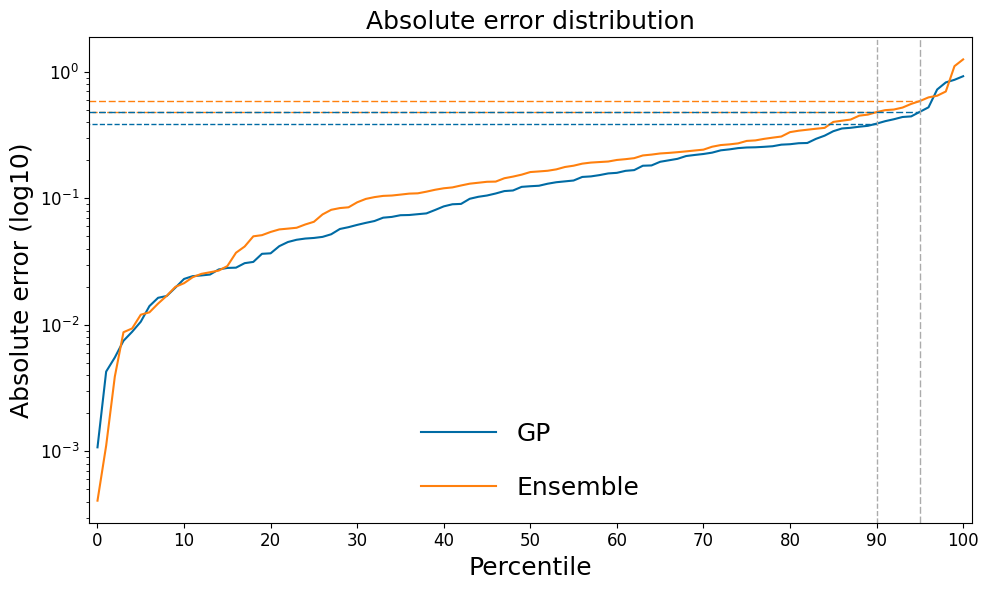

In [29]:
gp_errors = final_results_per_id['error'].to_list()
gp_absolute_errors = [abs(value) for value in gp_errors]
ensemble_cnn_errors = ensemble_cnn_df['Abs_error'].to_list()
ensemble_cnn_absolute_errors = [abs(value) for value in ensemble_cnn_errors]

percentiles = np.arange(0, 101, 1)
gp_error_percentiles = np.percentile(gp_absolute_errors, percentiles)
ensemble_cnn_error_percentiles = np.percentile(ensemble_cnn_absolute_errors, percentiles)

gp_y_at_90th_percentile = gp_error_percentiles[90]
ensemble_y_at_90th_percentile = ensemble_cnn_error_percentiles[90]
gp_y_at_95th_percentile = gp_error_percentiles[95]
ensemble_y_at_95th_percentile = ensemble_cnn_error_percentiles[95]
print(
	f'''90th percentile
GP {gp_y_at_90th_percentile}
Ensemble {ensemble_y_at_90th_percentile}

95th percentile
GP {gp_y_at_95th_percentile}
Ensemble {ensemble_y_at_95th_percentile}'''
)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, gp_error_percentiles, linestyle='-', color='#006BA4', label='GP')
plt.plot(percentiles, ensemble_cnn_error_percentiles, linestyle='-', color='#FF800E', label='Ensemble')
plt.plot([-10, 90], [gp_y_at_90th_percentile, gp_y_at_90th_percentile], color='#006BA4', linestyle='--', linewidth=1)
plt.plot([-10, 90], [ensemble_y_at_90th_percentile, ensemble_y_at_90th_percentile], color='#FF800E', linestyle='--', linewidth=1)
plt.plot([-10, 95], [gp_y_at_95th_percentile, gp_y_at_95th_percentile], color='#006BA4', linestyle=(0, (5, 2)), linewidth=1)
plt.plot([-10, 95], [ensemble_y_at_95th_percentile, ensemble_y_at_95th_percentile], color='#FF800E', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=95, color='#ABABAB', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=90, color='#ABABAB', linestyle='--', linewidth=1)
plt.yscale('log')
plt.title('Absolute error distribution', fontsize=18)
plt.xlabel('Percentile', fontsize=18)
plt.ylabel('Absolute error (log10)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(np.arange(0, 101, 10))  # Setting x-axis values in steps of 10
plt.legend(
	fontsize=18,  # Font size
	loc='lower center',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
plt.xlim((-1.0, 101.0))
plt.tight_layout()
plt.show()

In [30]:
# abolute error percentiles for below and above threshold
threshold = 5 # 10**5 = 100000, log10(100000) = 5
GP_below_threshold = final_results_per_id[final_results_per_id['y_true'] < threshold]
GP_above_threshold = final_results_per_id[final_results_per_id['y_true'] >= threshold]
ensemble_below_threshold = ensemble_cnn_df[ensemble_cnn_df['Actual'] < threshold]
ensemble_above_threshold = ensemble_cnn_df[ensemble_cnn_df['Actual'] >= threshold]

90th percentile
	GP 0.8067813168058149
	Ensemble 0.49488136570283703

95th percentile
	GP 0.8463226589076337
	Ensemble 0.7240127339959903


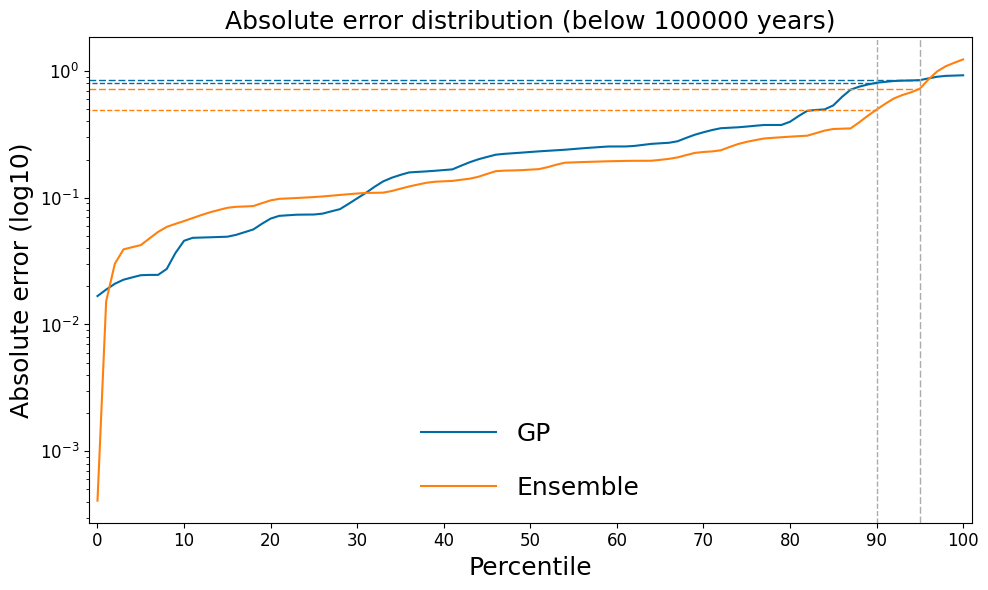

In [31]:
# Below hreshold
gp_errors = GP_below_threshold['error'].to_list()
gp_absolute_errors = [abs(value) for value in gp_errors]
ensemble_cnn_errors = ensemble_below_threshold['Abs_error'].to_list()
ensemble_cnn_absolute_errors = [abs(value) for value in ensemble_cnn_errors]

percentiles = np.arange(0, 101, 1)
gp_error_percentiles = np.percentile(gp_absolute_errors, percentiles)
ensemble_cnn_error_percentiles = np.percentile(ensemble_cnn_absolute_errors, percentiles)

gp_y_at_90th_percentile = gp_error_percentiles[90]
ensemble_y_at_90th_percentile = ensemble_cnn_error_percentiles[90]
gp_y_at_95th_percentile = gp_error_percentiles[95]
ensemble_y_at_95th_percentile = ensemble_cnn_error_percentiles[95]
print(
	f'''90th percentile
	GP {gp_y_at_90th_percentile}
	Ensemble {ensemble_y_at_90th_percentile}

95th percentile
	GP {gp_y_at_95th_percentile}
	Ensemble {ensemble_y_at_95th_percentile}'''
)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, gp_error_percentiles, linestyle='-', color='#006BA4', label='GP')
plt.plot(percentiles, ensemble_cnn_error_percentiles, linestyle='-', color='#FF800E', label='Ensemble')
plt.plot([-10, 90], [gp_y_at_90th_percentile, gp_y_at_90th_percentile], color='#006BA4', linestyle='--', linewidth=1)
plt.plot([-10, 90], [ensemble_y_at_90th_percentile, ensemble_y_at_90th_percentile], color='#FF800E', linestyle='--', linewidth=1)
plt.plot([-10, 95], [gp_y_at_95th_percentile, gp_y_at_95th_percentile], color='#006BA4', linestyle=(0, (5, 2)), linewidth=1)
plt.plot([-10, 95], [ensemble_y_at_95th_percentile, ensemble_y_at_95th_percentile], color='#FF800E', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=95, color='#ABABAB', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=90, color='#ABABAB', linestyle='--', linewidth=1)
plt.yscale('log')
plt.title('Absolute error distribution (below 100000 years)', fontsize=18)
plt.xlabel('Percentile', fontsize=18)
plt.ylabel('Absolute error (log10)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(np.arange(0, 101, 10))
plt.legend(
	fontsize=18,  # Font size
	loc='lower center',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
plt.xlim((-1.0, 101.0))
plt.tight_layout()
plt.show()

90th percentile
	GP 0.34635175890497094
	Ensemble 0.46747136996653194

95th percentile
	GP 0.41442336502009225
	Ensemble 0.5515709798211945


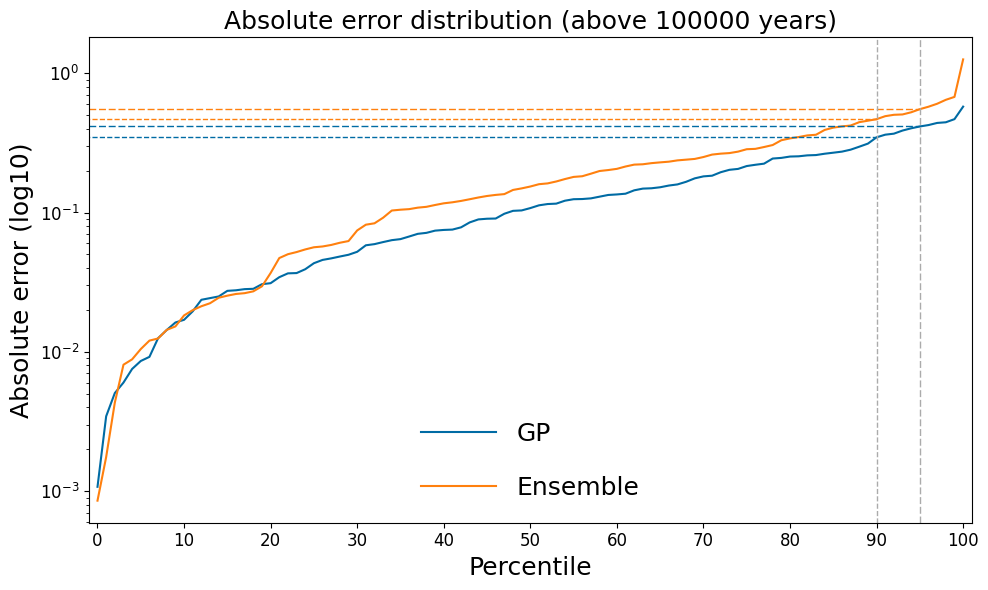

In [32]:
# Above hreshold
gp_errors = GP_above_threshold['error'].to_list()
gp_absolute_errors = [abs(value) for value in gp_errors]
ensemble_cnn_errors = ensemble_above_threshold['Abs_error'].to_list()
ensemble_cnn_absolute_errors = [abs(value) for value in ensemble_cnn_errors]

percentiles = np.arange(0, 101, 1)
gp_error_percentiles = np.percentile(gp_absolute_errors, percentiles)
ensemble_cnn_error_percentiles = np.percentile(ensemble_cnn_absolute_errors, percentiles)

gp_y_at_90th_percentile = gp_error_percentiles[90]
ensemble_y_at_90th_percentile = ensemble_cnn_error_percentiles[90]
gp_y_at_95th_percentile = gp_error_percentiles[95]
ensemble_y_at_95th_percentile = ensemble_cnn_error_percentiles[95]
print(
	f'''90th percentile
	GP {gp_y_at_90th_percentile}
	Ensemble {ensemble_y_at_90th_percentile}

95th percentile
	GP {gp_y_at_95th_percentile}
	Ensemble {ensemble_y_at_95th_percentile}'''
)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, gp_error_percentiles, linestyle='-', color='#006BA4', label='GP')
plt.plot(percentiles, ensemble_cnn_error_percentiles, linestyle='-', color='#FF800E', label='Ensemble')
plt.plot([-10, 90], [gp_y_at_90th_percentile, gp_y_at_90th_percentile], color='#006BA4', linestyle='--', linewidth=1)
plt.plot([-10, 90], [ensemble_y_at_90th_percentile, ensemble_y_at_90th_percentile], color='#FF800E', linestyle='--', linewidth=1)
plt.plot([-10, 95], [gp_y_at_95th_percentile, gp_y_at_95th_percentile], color='#006BA4', linestyle=(0, (5, 2)), linewidth=1)
plt.plot([-10, 95], [ensemble_y_at_95th_percentile, ensemble_y_at_95th_percentile], color='#FF800E', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=95, color='#ABABAB', linestyle=(0, (5, 2)), linewidth=1)
plt.axvline(x=90, color='#ABABAB', linestyle='--', linewidth=1)
plt.yscale('log')
plt.title('Absolute error distribution (above 100000 years)', fontsize=18)
plt.xlabel('Percentile', fontsize=18)
plt.ylabel('Absolute error (log10)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(np.arange(0, 101, 10))
plt.legend(
	fontsize=18,  # Font size
	loc='lower center',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
plt.xlim((-1.0, 101.0))
plt.tight_layout()
plt.show()

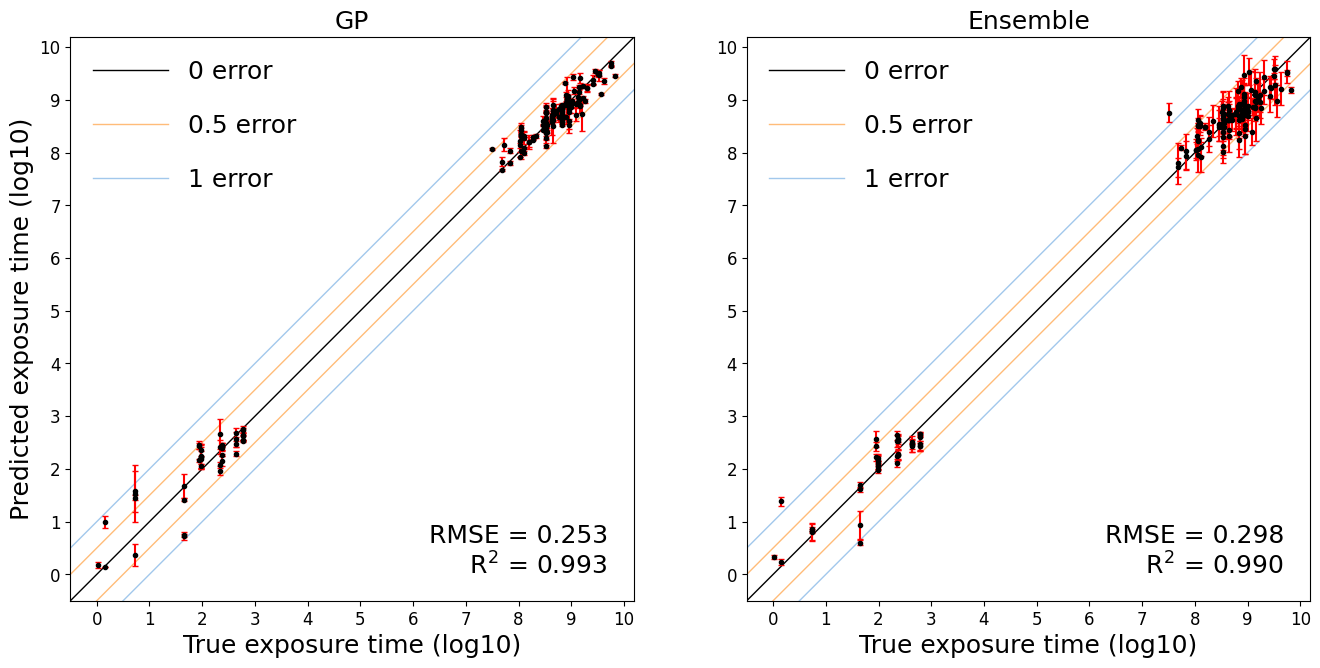

In [33]:
gp_actual = final_results_per_id['y_true']
gp_predicted = final_results_per_id['y_pred_average']
gp_std = final_results_per_id['standard_deviation']

cnn_tree_actual = ensemble_cnn_df['Actual']
cnn_tree_predicted = ensemble_cnn_df['Predicted']
cnn_tree_std = ensemble_cnn_df['STD']

true_line = pd.Series([-1, 12])
interval1 = true_line-1
interval2 = true_line-0.5
interval3 = true_line+0.5
interval4 = true_line+1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.plot(true_line, true_line, color='black', linestyle='-', linewidth=1, label='0 error')
ax1.plot(true_line, interval2, color='#FFBC79', linestyle='-', linewidth=1, label='0.5 error')
ax1.plot(true_line, interval1, color='#A2C8EC', linestyle='-', linewidth=1, label='1 error')
ax1.plot(true_line, interval3, color='#FFBC79', linestyle='-', linewidth=1)
ax1.plot(true_line, interval4, color='#A2C8EC', linestyle='-', linewidth=1)
ax1.errorbar(gp_actual, gp_predicted, yerr=[gp_std, gp_std], capsize=2, fmt='.', color='black', ecolor='red', alpha=1)
ax1.set_xlim(-0.5, max(gp_predicted) + 0.5)
ax1.set_ylim(-0.5, max(gp_predicted) + 0.5)
ax1.set_xticks(np.arange(0, max(y_test)+1.1, 1))
ax1.set_yticks(np.arange(0, max(y_test)+1.1, 1))
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=12)
ax1.set_xlabel('True exposure time (log10)', fontsize=18)
ax1.set_ylabel('Predicted exposure time (log10)', fontsize=18)
ax1.set_title('GP', fontsize=18)
ax1.legend(
	fontsize=18,  # Font size
	loc='upper left',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
ax1.text(
	8, 0,  # Position of the text box
	f'RMSE = {gp_RMSE:.3f}\n     R$^2$ = {gp_R2:.3f}', # Text
	fontsize=18,  # Font size
	bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'),  # Box properties
	ha='center'
)
ax1.set_aspect('equal', adjustable='box')

ax2.plot(true_line, true_line, color='black', linestyle='-', linewidth=1, label='0 error')
ax2.plot(true_line, interval2, color='#FFBC79', linestyle='-', linewidth=1, label='0.5 error')
ax2.plot(true_line, interval1, color='#A2C8EC', linestyle='-', linewidth=1, label='1 error')
ax2.plot(true_line, interval3, color='#FFBC79', linestyle='-', linewidth=1)
ax2.plot(true_line, interval4, color='#A2C8EC', linestyle='-', linewidth=1)
ax2.errorbar(cnn_tree_actual, cnn_tree_predicted, yerr=[cnn_tree_std, cnn_tree_std], capsize=2, fmt='.', color='black', ecolor='red', alpha=1)
ax2.set_xlim(-0.5, max(gp_predicted) + 0.5)
ax2.set_ylim(-0.5, max(gp_predicted) + 0.5)
ax2.set_xticks(np.arange(0, max(y_test)+1.1, 1))
ax2.set_yticks(np.arange(0, max(y_test)+1.1, 1))
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax2.set_xlabel('True exposure time (log10)', fontsize=18)
# ax2.set_ylabel('Predicted exposure time (log10)', fontsize=18)
ax2.set_title('Ensemble', fontsize=18)
ax2.legend(
	fontsize=18,  # Font size
	loc='upper left',  # Location
	frameon=False,  # Frame around the legend
	labelspacing=1.2,  # Spacing between labels
	handlelength=3  # Length of the legend handles
)
ax2.text(
	8, 0,  # Position of the text box
	f'RMSE = {ensemble_RMSE:.3f}\n     R$^2$ = {ensemble_R2:.3f}', # Text
	fontsize=18,  # Font size
	bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'),  # Box properties
	ha='center'
)
ax2.set_aspect('equal', adjustable='box')

# plt.tight_layout()
plt.show()